Processing AAPL...
Epoch 1/50


C:\Users\majdt\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\majdt\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\majdt\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\majdt\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\majdt\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\majdt\

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.3723 - mse: 0.3717 - val_loss: 0.3224 - val_mse: 0.3261
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1223 - mse: 0.1220 - val_loss: 0.0106 - val_mse: 0.0104
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0218 - mse: 0.0217 - val_loss: 0.0181 - val_mse: 0.0183
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0040 - val_mse: 0.0039
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - mse: 0.0021 - v

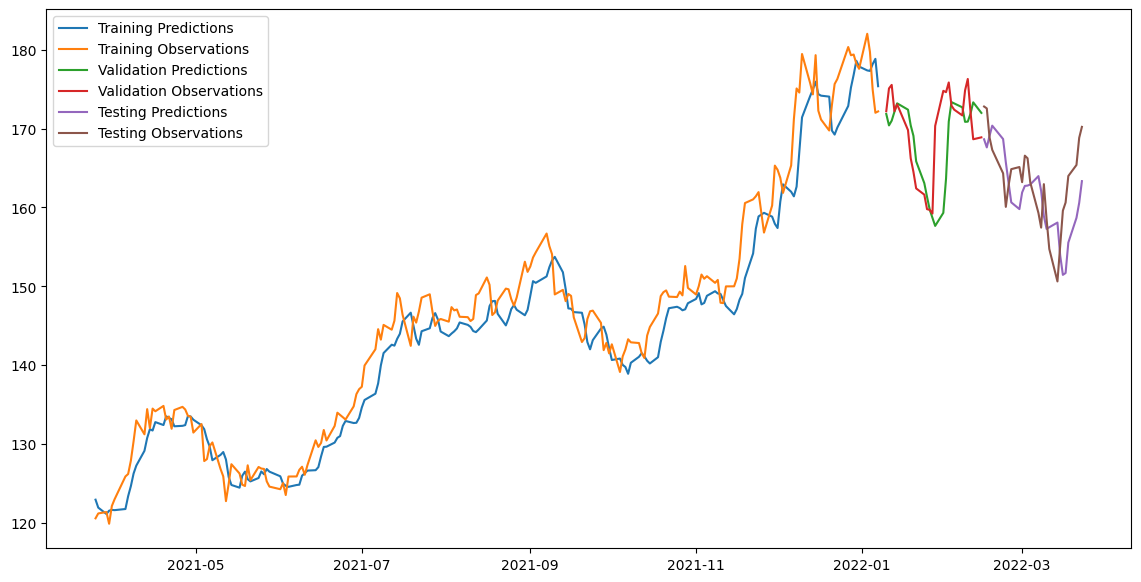

C:\Users\majdt\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\majdt\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\majdt\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\majdt\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\majdt\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\majdt\

Processing GOOGL...
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.5690 - mse: 0.5682 - val_loss: 0.2756 - val_mse: 0.2821
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1444 - mse: 0.1442 - val_loss: 0.0424 - val_mse: 0.0422
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0339 - mse: 0.0339 - val_loss: 0.0094 - val_mse: 0.0102
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0019 - val_mse: 0.0022
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0018 - val_mse: 0.0021
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0021 - val_mse: 0.0024
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0018 - val_mse: 0.0021
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - mse: 0.0019 - val_loss: 0.0020 - val_mse: 0.0023
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step -

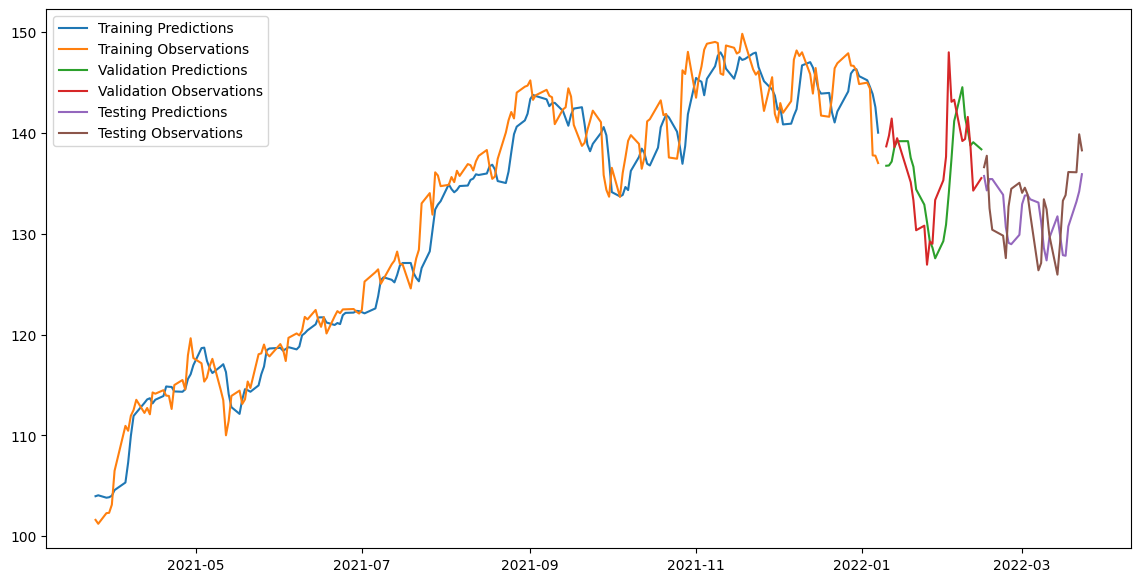

C:\Users\majdt\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\majdt\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\majdt\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\majdt\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\majdt\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\majdt\

Processing MSFT...
Epoch 1/50


C:\Users\majdt\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\majdt\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\majdt\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\majdt\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\majdt\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\majdt\

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.4969 - mse: 0.4960 - val_loss: 0.2802 - val_mse: 0.2790
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1630 - mse: 0.1626 - val_loss: 0.0181 - val_mse: 0.0185
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0277 - mse: 0.0276 - val_loss: 0.0048 - val_mse: 0.0046
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0021 - val_mse: 0.0020
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0014 - val_mse: 0.0013
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 9.3394e-04 - val_mse: 9.1155e-04
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0010 - val_mse: 9.9329e-04
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mse

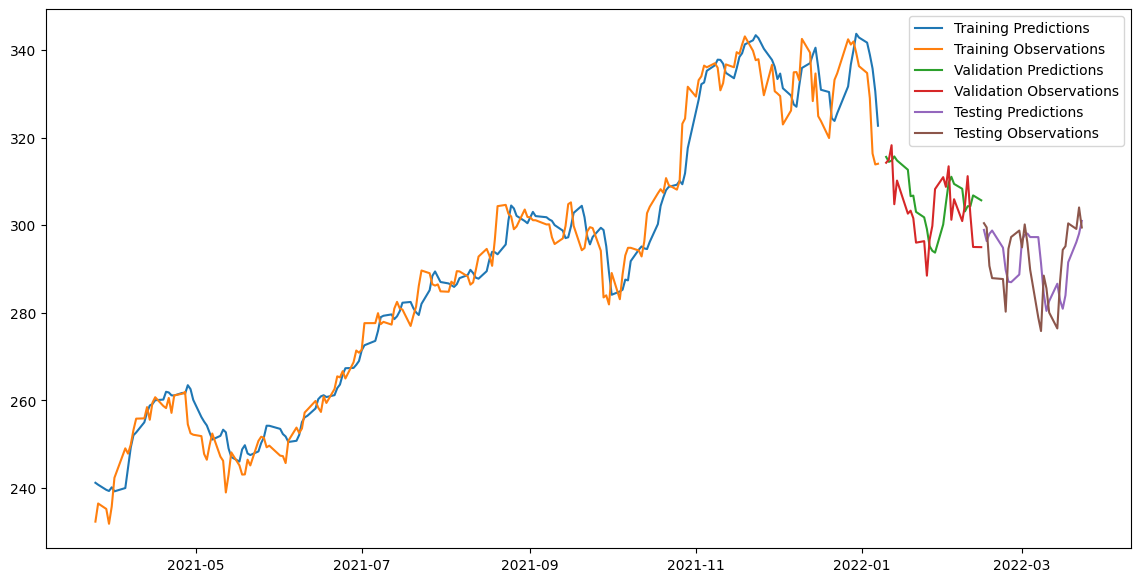

In [30]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.saving import register_keras_serializable
import joblib
import tensorflow as tf

# Define the stock symbols and data directory
stock_symbols = ['AAPL', 'GOOGL', 'MSFT']
data_dir = 'data'

# Register the custom metric function
@register_keras_serializable()
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

# Function to convert string to datetime
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

# Function to create windowed dataframe
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)
    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

# Function to split data into train, validation, and test sets
def split_data(dates, X, y, q_80, q_90):
    dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
    dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
    dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]
    return dates_train, X_train, y_train, dates_val, X_val, y_val, dates_test, X_test, y_test

# Function to create LSTM model
def create_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        LSTM(64, return_sequences=False),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=[mse])
    return model

# Function to train the model
def train_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16)

# Function to plot predictions
def plot_predictions(dates_train, y_train, train_predictions, dates_val, y_val, val_predictions, dates_test, y_test, test_predictions):
    plt.figure(figsize=(14, 7))
    plt.plot(dates_train, train_predictions, label='Training Predictions')
    plt.plot(dates_train, y_train, label='Training Observations')
    plt.plot(dates_val, val_predictions, label='Validation Predictions')
    plt.plot(dates_val, y_val, label='Validation Observations')
    plt.plot(dates_test, test_predictions, label='Testing Predictions')
    plt.plot(dates_test, y_test, label='Testing Observations')
    plt.legend(['Training Predictions', 'Training Observations', 'Validation Predictions', 'Validation Observations', 'Testing Predictions', 'Testing Observations'])
    plt.show()

# Process each stock symbol
for symbol in stock_symbols:
    print(f'Processing {symbol}...')
    file_path = os.path.join(data_dir, f'{symbol}_data.csv')
    df = pd.read_csv(file_path)
    
    # Data processing
    df = df[['Date', 'Close']]
    df['Date'] = df['Date'].apply(str_to_datetime)
    df.index = df.pop('Date')

    # Create windowed dataframe
    windowed_df = df_to_windowed_df(df, '2021-03-25', '2022-03-23', n=3)
    dates, X, y = windowed_df['Target Date'], windowed_df.iloc[:, 1:-1].values, windowed_df['Target'].values

    # Split the data
    q_80 = int(len(dates) * 0.8)
    q_90 = int(len(dates) * 0.9)
    dates_train, X_train, y_train, dates_val, X_val, y_val, dates_test, X_test, y_test = split_data(dates, X, y, q_80, q_90)

    # Fit the scaler on the 'Close' prices
    scaler = MinMaxScaler()
    scaler.fit(df[['Close']])

    # Save the scaler
    joblib.dump(scaler, os.path.join('models', f'{symbol}_scaler.pkl'))

    # Scale the target values (y)
    y_train = scaler.transform(y_train.reshape(-1, 1))
    y_val = scaler.transform(y_val.reshape(-1, 1))
    y_test = scaler.transform(y_test.reshape(-1, 1))

    # Scale the features (X)
    X_train_scaled = np.array([scaler.transform(window.reshape(-1, 1)).flatten() for window in X_train])
    X_val_scaled = np.array([scaler.transform(window.reshape(-1, 1)).flatten() for window in X_val])
    X_test_scaled = np.array([scaler.transform(window.reshape(-1, 1)).flatten() for window in X_test])

    # Reshape the data to have three dimensions
    X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
    X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

    # Create and train the model
    model = create_model(X_train_scaled.shape[1:])
    train_model(model, X_train_scaled, y_train, X_val_scaled, y_val)

    # Get predictions
    train_predictions = model.predict(X_train_scaled).flatten()
    val_predictions = model.predict(X_val_scaled).flatten()
    test_predictions = model.predict(X_test_scaled).flatten()

    # Inverse transform the predictions to original scale
    train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1)).flatten()
    val_predictions = scaler.inverse_transform(val_predictions.reshape(-1, 1)).flatten()
    test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

    # Inverse transform the actual values to original scale
    y_train = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
    y_val = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Plot predictions
    plot_predictions(dates_train, y_train, train_predictions, dates_val, y_val, val_predictions, dates_test, y_test, test_predictions)
    
    # Save the model
    model.save(os.path.join('models', f'{symbol}_lstm_model.h5'))
